In [1]:
import down_data
import importlib
importlib.reload(down_data)
import pandas as pd
import time

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.options.display.max_colwidth = 100
%matplotlib inline

In [31]:
def extract_coin_columns(df, coin_name):
    return df.loc[:, df.columns.str.endswith('_' + coin_name)]

def plot_coin(df):
    coin_name = df.columns[0].split('_')[1]
    
    ax = df.loc[:, df.columns.str.startswith('open')].plot(figsize=(20,10), title=coin_name, style='.-')
    ax = df.loc[:, df.columns.str.startswith('close')].plot(figsize=(20,10), ax=ax, style='.-')
    ax = df.loc[:, df.columns.str.startswith('high')].plot(figsize=(20,10), ax=ax, style='.-')
    df.loc[:, df.columns.str.startswith('low')].plot(figsize=(20,10), ax=ax, style='.-')

In [3]:
coins_list_btc_small = ['SYS','BCN','DGB']
coins_list_btc = ['SYS','BCN','DGB','LBC','NOTE','PASC','NAUT','SC','NEOS','ETH','ZEC','MAID','XRP',
                  'BTS','XEM','SBD','STRAT','LTC','AMP','BCY','ETC','ARDR','POT','NXT','BELA','XBC',
                  'BTCD','XMR','NXC','XCP','DCR','BLK','RIC','STEEM','NMC','PINK','OMNI','SJCX','NAV']

In [4]:
down = down_data.Downloader()

In [9]:
df_big = pd.DataFrame()
coin_btc_previous = ''

for coin_btc in coins_list_btc:
    print(coin_btc)
    histominute = down.get_histominute_json(coin_btc, 'BTC', limit=2000, aggregate=30)
    if len(df_big) == 0:
        df_big = pd.DataFrame(histominute['Data']).add_suffix('_' + coin_btc)
    else:
        df_small = pd.DataFrame(histominute['Data']).add_suffix('_' + coin_btc)
        left_on='time_'+coin_btc_previous
        right_on='time_'+coin_btc
        df_big = pd.merge(df_big, df_small, left_on=left_on, right_on=right_on)
    coin_btc_previous = coin_btc
    time.sleep(0.1)

SYS
get_histominute request: https://min-api.cryptocompare.com/data/histominute?&fsym=SYS&tsym=BTC&limit=2000&aggregate=30&e=Poloniex
BCN
get_histominute request: https://min-api.cryptocompare.com/data/histominute?&fsym=BCN&tsym=BTC&limit=2000&aggregate=30&e=Poloniex
DGB
get_histominute request: https://min-api.cryptocompare.com/data/histominute?&fsym=DGB&tsym=BTC&limit=2000&aggregate=30&e=Poloniex
LBC
get_histominute request: https://min-api.cryptocompare.com/data/histominute?&fsym=LBC&tsym=BTC&limit=2000&aggregate=30&e=Poloniex
NOTE
get_histominute request: https://min-api.cryptocompare.com/data/histominute?&fsym=NOTE&tsym=BTC&limit=2000&aggregate=30&e=Poloniex
PASC
get_histominute request: https://min-api.cryptocompare.com/data/histominute?&fsym=PASC&tsym=BTC&limit=2000&aggregate=30&e=Poloniex
NAUT
get_histominute request: https://min-api.cryptocompare.com/data/histominute?&fsym=NAUT&tsym=BTC&limit=2000&aggregate=30&e=Poloniex
SC
get_histominute request: https://min-api.cryptocompar

In [11]:
df_big.head()

,close_SYS,high_SYS,low_SYS,open_SYS,time_SYS,volumefrom_SYS,volumeto_SYS,close_BCN,high_BCN,low_BCN,...,time_SJCX,volumefrom_SJCX,volumeto_SJCX,close_NAV,high_NAV,low_NAV,open_NAV,time_NAV,volumefrom_NAV,volumeto_NAV
0,0.000042,0.000042,0.000042,0.000042,1504168200,46824.30,1.969251,5.600000e-07,5.800000e-07,5.500000e-07,...,1504168200,3426.2723,0.732585,0.000160,0.000164,0.000158,0.000164,1504168200,14454.70,2.329050
1,0.000043,0.000043,0.000041,0.000042,1504170000,541160.58,22.516787,5.600000e-07,5.600000e-07,5.400000e-07,...,1504170000,1328.4500,0.284262,0.000160,0.000164,0.000160,0.000160,1504170000,23708.72,3.840020
2,0.000043,0.000043,0.000042,0.000043,1504171800,164106.40,7.037450,5.500000e-07,5.600000e-07,5.500000e-07,...,1504171800,2230.5700,0.475820,0.000161,0.000164,0.000160,0.000160,1504171800,12619.19,2.054504
3,0.000042,0.000043,0.000042,0.000043,1504173600,144692.49,6.198250,5.500000e-07,5.600000e-07,5.500000e-07,...,1504173600,5972.3500,1.267344,0.000157,0.000161,0.000155,0.000161,1504173600,21507.55,3.400279
4,0.000041,0.000042,0.000041,0.000042,1504175400,153300.58,6.381450,5.400000e-07,5.600000e-07,5.400000e-07,...,1504175400,9783.7200,2.086197,0.000158,0.000160,0.000155,0.000157,1504175400,16874.65,2.653353


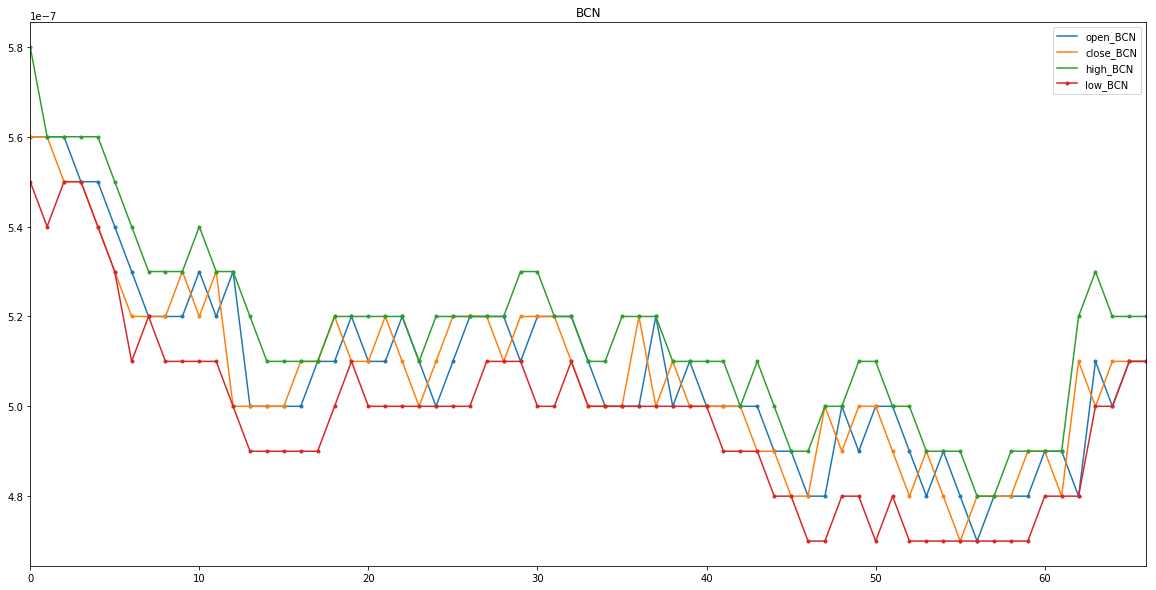

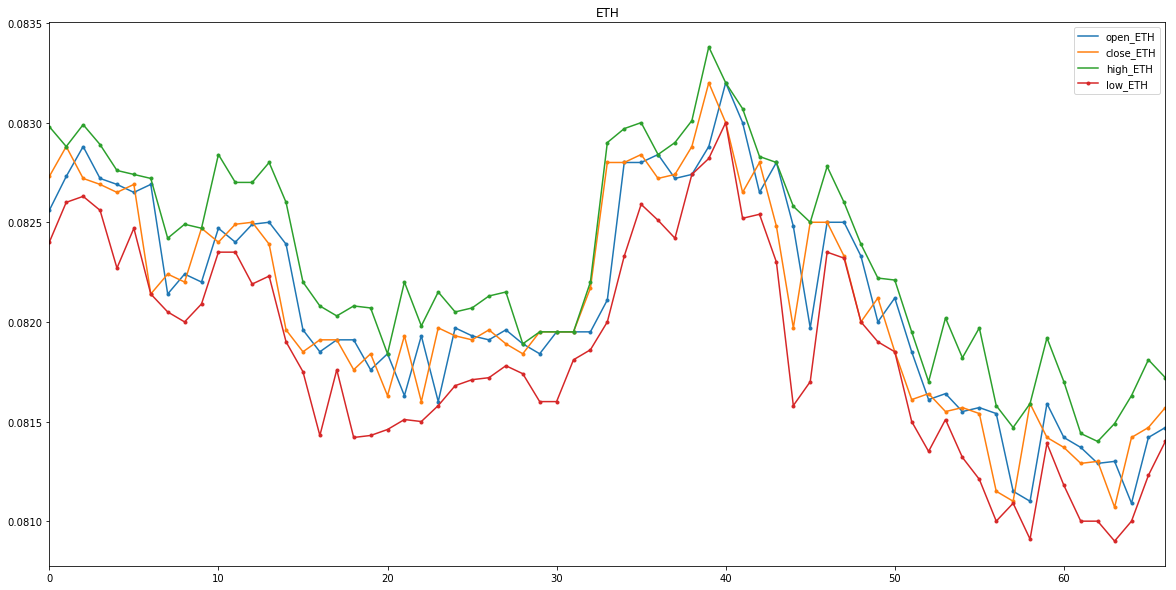

In [32]:
plot_coin(extract_coin_columns(df=df_big, coin_name='BCN'))
plot_coin(extract_coin_columns(df=df_big, coin_name='ETH'))